# Person Re-ID with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.datasets.reid import TripletDataGenerator, TestingDataGenerator
from vbranch.applications.cnn import SimpleCNNLarge
from vbranch.applications.resnet import ResNet50
from vbranch.applications.densenet import DenseNet121
from vbranch.callbacks import reid_acc
from vbranch.losses import triplet

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data_iterator_from_generator as get_iterator
from vbranch.utils.training import lr_exp_decay_scheduler, beta1_scheduler

Using TensorFlow backend.


In [3]:
SAVE = True
MODEL_ID = 1
ARCHITECTURE = 'densenet'
DATASET = 'market'
NUM_BRANCHES = 1
SHARED_FRAC = 0.5

EPOCHS = 250
STEPS_PER_EPOCH = 100
T_0 = 150
OUTPUT_DIM = 128

## Load Data

In [4]:
P, K = 18, 4
train_generator = TripletDataGenerator(DATASET, 'train')

In [5]:
batch = train_generator.next(4, 4, flatten=False, preprocess=ARCHITECTURE)
# for i in range(4):
#     for j in range(4):
#         plt.subplot(4, 4, 4*i+j+1)
#         plt.imshow(batch[i, j].squeeze(), cmap=plt.cm.gray)
#         plt.axis('off')
# plt.show()

In [6]:
batch.min(), batch.max()

(-2.0494049, 2.64)

## Build Model

In [7]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/market-densenet_1


In [8]:
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

tf.reset_default_graph()

inputs, train_init_op, test_init_op = get_iterator(train_generator, input_dim, 
                                                   P,K, ARCHITECTURE, n=NUM_BRANCHES)

(None, 256, 128, 3)
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
inputs

<tf.Tensor 'input:0' shape=(?, 256, 128, 3) dtype=float32>

In [10]:
lr = tf.placeholder('float32', name='lr')
beta1 = tf.placeholder('float32', shape=[], name='beta1')
lr_scheduler = lr_exp_decay_scheduler(0.0003, T_0, EPOCHS, 0.001)
beta1_sched = beta1_scheduler(T_0)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, 
                               shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'resnet':
        model, assign_ops = ResNet50(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
    elif ARCHITECTURE == 'densenet':
        model, assign_ops = DenseNet121(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1)

    # Compile model
    model.compile(optimizer, triplet(P,K), 
                  train_init_op, test_init_op, 
                  callbacks={'acc' : reid_acc(DATASET, NUM_BRANCHES, 
                                              preprocess=ARCHITECTURE, buffer=500)},
                  schedulers={'lr:0': lr_scheduler, 'beta1:0':beta1_sched},  
                  assign_ops=assign_ops)

Loading weights for DenseNet121...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [11]:
model.summary()

i    Layer name                      Output shape      Parameters          Num param  Inbound               
------------------------------------------------------------------------------------------------------------
     Input                           [None,256,128,3]                                                       
------------------------------------------------------------------------------------------------------------
0    zero_pad (ZeroPadding2D)        [None,262,134,3]                      0          input:0               
------------------------------------------------------------------------------------------------------------
1    conv1/conv (Conv2D)             [None,128,64,64]  [7,7,3,64]          9408       zero_pad              
------------------------------------------------------------------------------------------------------------
2    conv1/bn (BatchNormalization)   [None,128,64,64]  [64] [64]           128        conv1/conv            
-------------------

In [12]:
print(model.output)

Tensor("model/output/output:0", shape=(?, 128), dtype=float32)


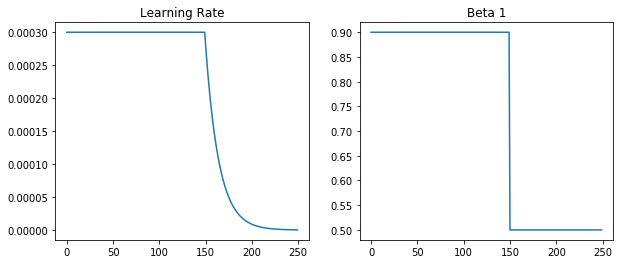

In [13]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
beta1_steps = [beta1_sched(e + 1) for e in range(EPOCHS)]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lr_steps)
plt.title('Learning Rate')

plt.subplot(1,2,2)
plt.plot(beta1_steps)
plt.title('Beta 1')

plt.show()

In [ ]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, log_path=model_path if SAVE else None, 
                    call_step=10, verbose=1)

Epoch 1/250
-2.117904 2.64
100/100 [==============================] - 91s 909ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 1036.9678
Epoch 2/250
100/100 [==============================] - 71s 707ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 450.8342
Epoch 3/250
100/100 [==============================] - 71s 707ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 255.7945
Epoch 4/250
100/100 [==============================] - 70s 704ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 171.7194
Epoch 5/250
100/100 [==============================] - 70s 699ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 125.5822
Epoch 6/250
100/100 [==============================] - 70s 699ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 101.4477
Epoch 7/250
100/100 [==============================] - 70s 700ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 81.0704
Epoch 8/250
100/100 [==============================] - 70s 703ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 80

Elapsed time: 19.37478733062744
100/100 [==============================] - 143s 1s/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 31.7575 - mAP: 0.5127 - rank1: 0.7135 - rank5: 0.8762
Epoch 51/250
100/100 [==============================] - 66s 661ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 23.4893
Epoch 52/250
100/100 [==============================] - 66s 658ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 21.8959
Epoch 53/250
100/100 [==============================] - 66s 661ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 29.4344
Epoch 54/250
100/100 [==============================] - 66s 661ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 23.0388
Epoch 55/250
100/100 [==============================] - 66s 661ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 36.2428
Epoch 56/250
100/100 [==============================] - 66s 661ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss: 20.8294
Epoch 57/250
100/100 [==============================] - 66s 662ms/ste